In [24]:
#std libs
from collections import OrderedDict

#non std libs
import torch
from torchvision.transforms import ToTensor
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

#custom libs
from mim_depth_destimation.models.model import GLPDepth

In [25]:
IMAGE_SIZE = [1242, 375]

In [26]:
class Storage:
    #a minimal storage class to somewhat mimic the behaviour of argparse.ArgumentParser
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs);

In [27]:
args = Storage(
    max_depth=80.0,
    backbone="swin_large_v2",
    depths=[2, 2, 18, 2],
    window_size=[22, 22, 22, 11],
    pretrain_window_size=[12, 12, 12, 6],
    drop_path_rate=0.3, #
    use_checkpoint=False, #
    use_shift=[True, True, False, False],
    pretrained='', #
    num_deconv=3, #
    num_filters=[32, 32, 32],
    deconv_kernels=[2, 2, 2],
) #TODO: add arguments

In [28]:
if torch.cuda.is_available():
    device = torch.device("cuda");
    device_prop = torch.cuda.get_device_properties(device);
    print(f"Using GPU: {device_prop.name} {round(device_prop.total_memory / 1024**3, 2)}GiB (CC: {device_prop.major}.{device_prop.minor})");
else:
    device = torch.device("cpu");
    print("Using CPU.");

Using GPU: NVIDIA GeForce RTX 2070 7.79GiB (CC: 7.5)


In [29]:
#TODO: maybe create output paths beforehand? ./mim_depth_destimation/test.py:39

In [30]:
model = GLPDepth(args=args);

model_weights: dict = torch.load("./checkpoints/kitti_swin_large.ckpt");
if 'module' in next(iter(model_weights.items()))[0]:
    model_weight = OrderedDict((k[7:], v) for k, v in model_weights.items())

model.load_state_dict(model_weights);
model.eval();

norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]


norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(22, 22)] ==> [12]
norm8_log_bylayer: [(11, 11)] ==> [6]
norm8_log_bylayer: [(11, 11)] ==> [6]


In [31]:
#mim_depth_destination.dataset.kitti.kitti.cropping
def crop(img):
    h_im, w_im = img.shape[:2]

    margin_top = int(h_im - 352)
    margin_left = int((w_im - 1216) / 2)

    img = img[margin_top:  margin_top  + 352,
              margin_left: margin_left + 1216]

    return img

In [32]:
img = cv.imread("/mnt/Daten2/Uni/Projektseminar_Robotik/presentation_images/normal.png");
img = cv.cvtColor(img, cv.COLOR_BGR2RGB);

In [43]:
#cropped_img = crop(img);
cropped_img = cv.resize(img, (1216, 352));

In [44]:
img_tensor = ToTensor()(cropped_img)
img_tensor = img_tensor[None, :, :, :]
#img_tensor = img_tensor.to(device);

In [45]:
with torch.no_grad():
    prediction = model(img_tensor);

In [46]:
pred_tensor = prediction["pred_d"]

In [47]:
print(tuple(pred_tensor.shape[2:]), cropped_img.shape[:2], sep='\n')

(352, 1216)
(352, 1216)


In [48]:
pred_image: np.ndarray = pred_tensor.numpy();
pred_image = pred_image.squeeze();

In [49]:
pred_image.shape

(352, 1216)

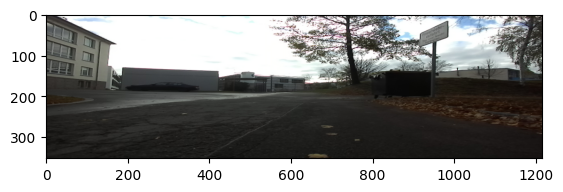

In [50]:
plt.imshow(cropped_img);

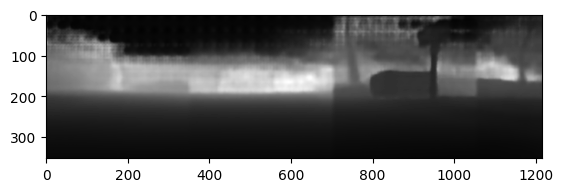

In [51]:
plt.imshow(pred_image, cmap="gray");

In [52]:
cv.imwrite("result.png", pred_image);